#### Imports

In [27]:
from kafka import KafkaProducer, KafkaConsumer
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import requests
import json
import os
from datetime import datetime, timedelta
import time
import schedule
import panel as pn
pn.extensions = ('tabulator')
import hvplot.pandas
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

#### Environment variables

In [7]:
# Load environment variables from .env file
load_dotenv()

# Access the API key from the environment variable
api_key = os.getenv("API_KEY")

##### Fetching data from api and seeing response in json

In [10]:
params = {
  'access_key': api_key
}

api_result = requests.get('http://api.marketstack.com/v1/tickers/aapl/eod', params)

api_response = api_result.json()

In [ ]:
api_response

In [ ]:
api_result = requests.get('http://api.marketstack.com/v1/tickers/KNEBV.XHEL/eod', params)

api_response = api_result.json()

In [ ]:
api_response

#### Functions

##### Function to fetch historic data from api (including latest end-of-day data)

In [11]:
# Function for fetching historic end-of-day data
def fetch_historic_data():
    params = {
        'access_key': api_key,
        'exchange': 'XNAS',
        'date_from': '2023-01-01',
        'limit': '1000'
    }
    
    response = requests.get('http://api.marketstack.com/v1/tickers/msft/eod', params)
    return response.json()

In [12]:
api_data = fetch_historic_data()
api_data

{'pagination': {'limit': 1000, 'offset': 0, 'count': 233, 'total': 233},
 'data': {'name': 'Microsoft Corporation',
  'symbol': 'MSFT',
  'country': None,
  'has_intraday': False,
  'has_eod': True,
  'eod': [{'open': 366.45,
    'high': 373.08,
    'low': 365.62,
    'close': 372.52,
    'volume': 23035900.0,
    'adj_high': 373.075,
    'adj_low': 365.621,
    'adj_close': 372.52,
    'adj_open': 366.45,
    'adj_volume': 23065035.0,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'MSFT',
    'exchange': 'XNAS',
    'date': '2023-12-05T00:00:00+0000'},
   {'open': 369.1,
    'high': 369.52,
    'low': 362.9,
    'close': 369.14,
    'volume': 32037800.0,
    'adj_high': 369.52,
    'adj_low': 362.9,
    'adj_close': 369.14,
    'adj_open': 369.1,
    'adj_volume': 32063305.0,
    'split_factor': 1.0,
    'dividend': 0.0,
    'symbol': 'MSFT',
    'exchange': 'XNAS',
    'date': '2023-12-04T00:00:00+0000'},
   {'open': 376.76,
    'high': 378.16,
    'low': 371.31,
    'cl

##### Function to fetch only latest end-of-day data

In [2]:
# Function for fetching only latest end-of-day data
def fetch_latest_data(): 
    params = {
        'access_key': api_key,
        'exchange': 'XNAS',
    }
    
    response = requests.get('http://api.marketstack.com/v1/tickers/msft/eod/latest', params)
    return response.json()

In [8]:
api_data = fetch_latest_data()
api_data

{'open': 373.54,
 'high': 374.18,
 'low': 368.03,
 'close': 368.8,
 'volume': 21160300.0,
 'adj_high': 374.18,
 'adj_low': 368.03,
 'adj_close': 368.8,
 'adj_open': 373.54,
 'adj_volume': 21118348.0,
 'split_factor': 1.0,
 'dividend': 0.0,
 'symbol': 'MSFT',
 'exchange': 'XNAS',
 'date': '2023-12-06T00:00:00+0000'}

##### Function to extract data from api response

In [11]:
# Function to select and extract data
def extract_data(response_data):
    if 'eod' not in response_data.get('data', {}):
        # Assume latest end-of-day data structure
        parsed_date = datetime.strptime(response_data.get('date'), '%Y-%m-%dT%H:%M:%S%z')
        formatted_date = parsed_date.strftime('%Y-%m-%d')

        entry = {
            'open': float(response_data.get('open')),
            'high': float(response_data.get('high')),
            'low': float(response_data.get('low')),
            'close': float(response_data.get('close')),
            'volume': int(response_data.get('volume')),
            'symbol': response_data.get('symbol'),
            'exchange': response_data.get('exchange'),
            'date': formatted_date
        }

        return [entry]
    else:
        # Assume historic data structure
        eod_data = response_data['data']['eod']

        extracted_data = []
        for day_data in eod_data:
            parsed_date = datetime.strptime(day_data.get('date'), '%Y-%m-%dT%H:%M:%S%z')
            formatted_date = parsed_date.strftime('%Y-%m-%d')

            entry = {
                'open': float(day_data.get('open')),
                'high': float(day_data.get('high')),
                'low': float(day_data.get('low')),
                'close': float(day_data.get('close')),
                'volume': int(day_data.get('volume')),
                'symbol': day_data.get('symbol'),
                'exchange': day_data.get('exchange'),
                'date': formatted_date
            }
            extracted_data.append(entry)

        return extracted_data

In [12]:
selected_data = extract_data(api_data)
selected_data

[{'open': 373.54,
  'high': 374.18,
  'low': 368.03,
  'close': 368.8,
  'volume': 21160300,
  'symbol': 'MSFT',
  'exchange': 'XNAS',
  'date': '2023-12-06'}]

##### Function to produce to Kafka topic

In [13]:
# Function to produce data to Kafka
def produce_to_kafka(data):
    # Convert data to JSON string
    json_data = json.dumps(data)

    # Initialize Kafka producer 
    producer = KafkaProducer(
        bootstrap_servers='localhost:9092',
        value_serializer=lambda x: x.encode('utf-8'))

    # Send data from producer to topic
    producer.send('quickstart-events', value=json_data)
    producer.close()

In [14]:
produce_to_kafka(selected_data)

##### Function to consume from Kafka topic

In [15]:
# Function to consume data from Kafka topic and store in Cassandra
def consume_and_store_in_cassandra():
    consumer = KafkaConsumer(
        'quickstart-events',
        bootstrap_servers = 'localhost:9092',
        auto_offset_reset = 'earliest',
        enable_auto_commit = True,
        group_id = 'my-group',
        value_deserializer = lambda x: json.loads(x.decode('utf-8')))

    # Connect to the Cassandra cluster
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    for message in consumer:
        try:
            # Assume the message is a list of dictionaries
            data = message.value

            # Check if required keys exist before accessing them
            for entry in data:
                # Insert data into Cassandra
                session.execute("""
                    INSERT INTO eod_data
                    (symbol, exchange, date, open, high, low, close, volume)
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                """, (
                    entry['symbol'],
                    entry['exchange'],
                    entry['date'],
                    entry['open'],
                    entry['high'],
                    entry['low'],
                    entry['close'],
                    entry['volume']
                    ))

            print("Data inserted into Cassandra.")
        except Exception as e:
            print(f"Error processing message: {e}")

    # Close the Cassandra connection
    cluster.shutdown()

    # Close the Kafka consumer
    consumer.close()

In [16]:
consume_and_store_in_cassandra()

Data inserted into Cassandra.
Data inserted into Cassandra.


KeyboardInterrupt: 

##### Functions to schedule periodic fetch and store of latest end-of-day data

In [17]:
# Function to run parts of the program
def job():
    api_data = fetch_latest_data()
    selected_data = extract_data(api_data)
    produce_to_kafka(selected_data)
    consume_and_store_in_cassandra()

# Function to schedule when to run periodically
def schedule_job():
    # Schedule the job to run every weekday at midnight
    schedule.every().monday.at("00:00").do(job)
    schedule.every().tuesday.at("00:00").do(job)
    schedule.every().wednesday.at("00:00").do(job)
    schedule.every().thursday.at("00:00").do(job)
    schedule.every().friday.at("00:00").do(job)

# Function to run scheduler loop
def run_schedule():
    schedule_job()
    # Run the schedule
    try:
        while True:
            schedule.run_pending()
            time.sleep(1)
    except KeyboardInterrupt:
        print("Scheduler stopped.")

run_schedule()

Scheduler stopped.


## Get data from Cassandra and visualization test

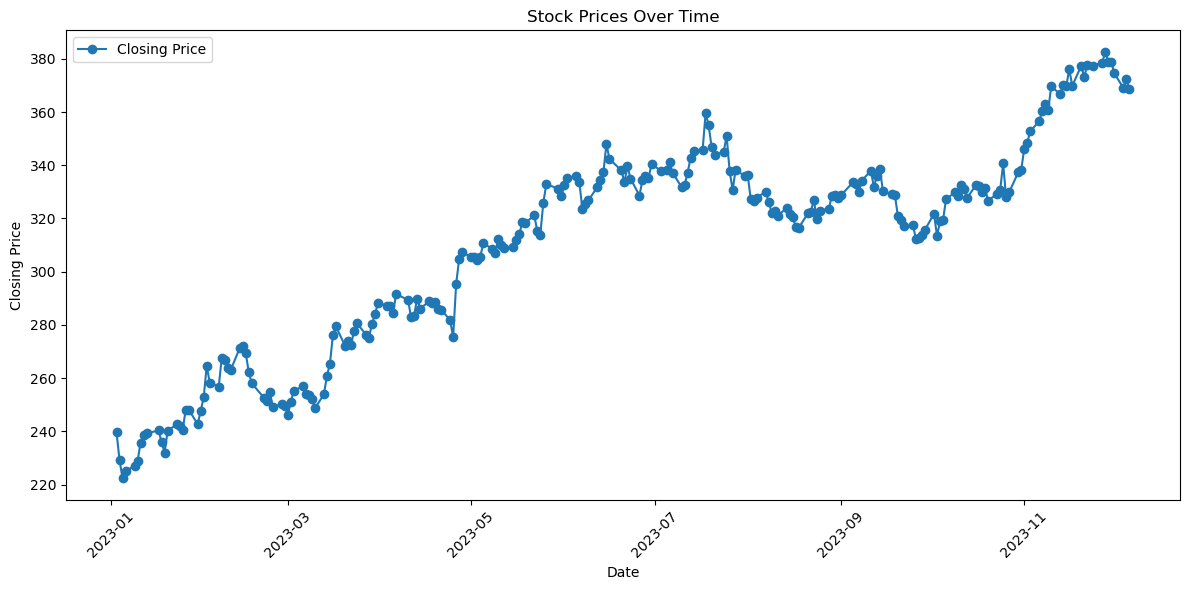

In [18]:
def fetch_data_from_cassandra():
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    rows = session.execute('SELECT * FROM eod_data')
    
    data = {
        'date': [],
        'close': []
    }

    for row in rows:
        # Convert Date type to string, then convert to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()
        data['date'].append(date_obj)
        data['close'].append(row.close)

    cluster.shutdown()
    return data

def plot_stock_prices(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['close'], label='Closing Price', marker='o')
    plt.title('Stock Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Fetch data from Cassandra and plot
cassandra_data = fetch_data_from_cassandra()
plot_stock_prices(cassandra_data)


# Stock price overtime

In [22]:
def fetch_data_from_cassandra():
    # Connect to the Cassandra cluster
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    # Fetch data from Cassandra
    rows = session.execute('SELECT * FROM eod_data')

    # Convert Cassandra rows to a DataFrame
    data = {'symbol': [], 'exchange': [], 'date': [], 'close': [], 'high': [], 'low': [], 'open': [], 'volume': []}
    for row in rows:
        data['symbol'].append(row.symbol)
        data['exchange'].append(row.exchange)

        # Convert Cassandra date to string, then to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()

        data['date'].append(date_obj)
        data['close'].append(row.close)
        data['high'].append(row.high)
        data['low'].append(row.low)
        data['open'].append(row.open)
        data['volume'].append(row.volume)

    df = pd.DataFrame(data)

    # Close the Cassandra connection
    cluster.shutdown()

    return df

# Fetch data from Cassandra
cassandra_data = fetch_data_from_cassandra()

# Plotting the closing prices over time
fig = px.line(cassandra_data, x='date', y='close', title='Stock Closing Prices Over Time',
                labels={'close': 'Closing Price', 'date': 'Date'})

# Show the plot
fig.show()

# Attempt at forecasting the stock closing price

In [23]:
def fetch_data_from_cassandra():
    # Connect to the Cassandra cluster
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    # Fetch data from Cassandra
    rows = session.execute('SELECT * FROM eod_data')

    # Convert Cassandra rows to a DataFrame
    data = {'symbol': [], 'exchange': [], 'date': [], 'close': [], 'high': [], 'low': [], 'open': [], 'volume': []}
    for row in rows:
        data['symbol'].append(row.symbol)
        data['exchange'].append(row.exchange)

        # Convert Cassandra date to string, then to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()

        data['date'].append(date_obj)
        data['close'].append(row.close)
        data['high'].append(row.high)
        data['low'].append(row.low)
        data['open'].append(row.open)
        data['volume'].append(row.volume)

    df = pd.DataFrame(data)

    # Close the Cassandra connection
    cluster.shutdown()

    return df

def forecast_stock_prices(data):
    # Use ARIMA for forecasting
    model = sm.tsa.ARIMA(data['close'], order=(5,1,0))  # Adjust order based on your data
    results = model.fit()

    # Forecast the next 5 days
    forecast_steps = 30
    forecast_values = results.forecast(steps=forecast_steps)

    # Add forecast values to the dataframe
    forecast_dates = [data['date'].max() + timedelta(days=i) for i in range(1, forecast_steps + 1)]
    forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast_values})

    return forecast_df

def check_sell_condition(data, threshold=500):
    if data['close'].max() >= threshold:
        print("Time to sell stocks!")

# Fetch data from Cassandra
cassandra_data = fetch_data_from_cassandra()

# Forecast stock prices
forecast_data = forecast_stock_prices(cassandra_data)

# Check sell condition
check_sell_condition(cassandra_data)

# Plotting the closing prices and forecast
fig = px.line(cassandra_data, x='date', y='close', title='Stock Closing Prices Over Time',
            labels={'close': 'Closing Price', 'date': 'Date'})

fig.add_scatter(x=forecast_data['date'], y=forecast_data['forecast'], mode='lines', name='Forecast')

# Show the plot
fig.show()

In [25]:
# Function to fetch data from Cassandra and convert to DataFrame
def fetch_data_from_cassandra():
    # Connect to the Cassandra cluster
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    # Fetch data from Cassandra
    rows = session.execute('SELECT * FROM eod_data')

    # Convert Cassandra rows to a DataFrame
    data = {'symbol': [], 'exchange': [], 'date': [], 'close': [], 'high': [], 'low': [], 'open': [], 'volume': []}
    for row in rows:
        data['symbol'].append(row.symbol)
        data['exchange'].append(row.exchange)

        # Convert Cassandra Date to string, then to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()

        data['date'].append(date_obj)
        data['close'].append(row.close)
        data['high'].append(row.high)
        data['low'].append(row.low)
        data['open'].append(row.open)
        data['volume'].append(row.volume)

    df = pd.DataFrame(data)

    # Close the Cassandra connection
    cluster.shutdown()

    return df

# Fetch data from Cassandra
df = fetch_data_from_cassandra()

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Chart 1: Line chart for closing prices over time
fig1 = df.hvplot(x='date', y='close', title='Closing Prices Over Time', width=800, height=400)

# Chart 2: Bar chart for volume over time
fig2 = df.hvplot.bar(x='date', y='volume', title='Volume Over Time', width=800, height=400)

# Chart 3: Candlestick chart for open, high, low, and close prices
fig3 = go.Figure(data=[go.Candlestick(x=df['date'],
                                        open=df['open'],
                                        high=df['high'],
                                        low=df['low'],
                                        close=df['close'])])
fig3.update_layout(title='Candlestick Chart', width=800, height=400)


# Chart 4: Scatter plot for high prices vs. low prices
fig4 = df.hvplot.scatter(x='high', y='low', title='High Prices vs. Low Prices', width=800, height=400)

# Combine the charts into a layout
layout = pn.Column(
    pn.panel(fig1),
    pn.panel(fig2),
    pn.panel(fig3),
    pn.panel(fig4),
)

# Display the dashboard
layout.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'2574b5f0-f41d-4c2e-8ed4-8da97921c959': {'version…

# The dashboard

You need to run cassandra and kafka inorder to work.

In [36]:
# Function to fetch data from Cassandra and convert to DataFrame
def fetch_data_from_cassandra():
    # Connect to the Cassandra cluster
    cluster = Cluster(['localhost'], port=9042)
    session = cluster.connect('stock_data')

    # Fetch data from Cassandra
    rows = session.execute('SELECT * FROM eod_data')

    # Convert Cassandra rows to a DataFrame
    data = {'symbol': [], 'exchange': [], 'date': [], 'close': [], 'high': [], 'low': [], 'open': [], 'volume': []}
    for row in rows:
        data['symbol'].append(row.symbol)
        data['exchange'].append(row.exchange)

        # Convert Cassandra Date to string, then to datetime object
        date_obj = datetime.strptime(str(row.date), '%Y-%m-%d').date()

        data['date'].append(date_obj)
        data['close'].append(row.close)
        data['high'].append(row.high)
        data['low'].append(row.low)
        data['open'].append(row.open)
        data['volume'].append(row.volume)

    df = pd.DataFrame(data)

    # Close the Cassandra connection
    cluster.shutdown()

    return df

# Fetch data from Cassandra
df = fetch_data_from_cassandra()

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# ARIMA model to forecast closing prices
time_series = df.set_index('date')['close']
order = (5, 1, 2)  
model = sm.tsa.ARIMA(time_series, order=order)
results = model.fit()

# Forecast the next 5 days
forecast_steps = 5
forecast_values = results.forecast(steps=forecast_steps)

# Add the forecast values to the DataFrame
last_date = df['date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast_close': forecast_values})
df = pd.concat([df, forecast_df], ignore_index=True)

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div(children=[
    html.H1(children='Stock Data Dashboard'),

    dcc.Graph(
        id='closing-prices',
        figure=px.line(df, x='date', y='close', title='Closing Prices Over Time')
    ),

    dcc.Graph(
        id='forecast',
        figure=px.line(df, x='date', y=['close', 'forecast_close'], title='Closing Price Forecast')
    ),

    dcc.Graph(
        id='volume',
        figure=px.bar(df, x='date', y='volume', title='Volume Over Time')
    ),

    dcc.Graph(
        id='candlestick',
        figure=go.Figure(data=[go.Candlestick(x=df['date'],
                                                open=df['open'],
                                                high=df['high'],
                                                low=df['low'],
                                                close=df['close'])],
                        layout=go.Layout(title='Candlestick Chart'))
    ),

    dcc.Graph(
        id='scatter-plot',
        figure=px.scatter(df, x='high', y='low', title='High Prices vs. Low Prices')
    ),
    html.Img(
        id='image-display',
        src='https://example.com/placeholder-image.jpg',  
        style={'width': '50%'}
    )
])

# Callback to update the image when closing price reaches a threshold
@app.callback(Output('image-display', 'src'),
                Input('closing-prices', 'hoverData'))
def update_image(hover_data):
    if hover_data:
        x_value = hover_data['points'][0]['x']
        closing_price = df[df['date'] == x_value]['close'].values[0]
        if closing_price >= 100:
            return 'https://example.com/success-image.jpg'  
    return 'https://example.com/placeholder-image.jpg'  

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


c:\Users\William\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\William\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

c:\Users\William\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\William\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

c:\Users\William\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no a

Exception in thread Thread-283 (<lambda>):
Traceback (most recent call last):
  File "c:\Users\William\anaconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\William\anaconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\William\anaconda3\Lib\site-packages\dash\dash.py", line 1756, in <lambda>
    target=lambda: _watch.watch(
                   ^^^^^^^^^^^^^
  File "c:\Users\William\anaconda3\Lib\site-packages\dash\_watch.py", line 35, in watch
    walk()
  File "c:\Users\William\anaconda3\Lib\site-packages\dash\_watch.py", line 20, in walk
    info = os.stat(path)
           ^^^^^^^^^^^^^
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\William\\anaconda3\\Lib\\site-packages\\dash\\html\\__pycache__\\Meter.cpython-311-pytest-7.4.0.pyc.31560'
Exception in thread Thread-22 (<lambda>):
Traceback (most recent call last):
  File "c:\Users\William\anaconda3\Lib\th